In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
sys.path.append('../scripts')
from scripts.data_handler import DataOrganize, DataModes


c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:

data_organize = DataOrganize()
data_organize.create_clean_data(mode=DataModes.RANDOM_1000)

100%|██████████| 715/715 [00:00<00:00, 56773.14it/s]

day type :<class 'datetime.date'>


,body,created_at,user.followers,entities.sentiment.basic,Day
0,$DOGE.X gained watchers,2023-04-16T21:31:28Z,86,Bullish,2023-04-16
1,$DOGE.X a lil boop,2023-07-11T23:22:59Z,75,Bullish,2023-07-11
2,$XRP.X This guy is the 🤡,2023-07-20T14:43:06Z,39,Bullish,2023-07-20
3,$XRP.X So the best way to stay long without sw...,2023-06-12T02:35:00Z,199,NaN,2023-06-12
5,$BTC.X BITCOIN IS SAFE! 15TH YEAR TODAY! This ...,2023-10-31T20:42:38Z,177,Bullish,2023-10-31
...,...,...,...,...,...
993,$CLSK miners should be up huge tomorrow!!! Can...,2023-10-23T03:59:30Z,4,Bullish,2023-10-23
994,$XRP.X definition of retardation ⬇️😂they try ...,2023-11-13T21:32:24Z,29,NaN,2023-11-13
995,$AVAX.X $SOL.X finally I&#39;m green on both p...,2023-01-11T23:00:57Z,145,Bullish,2023-01-11
996,$XRP.X so...what&#39;s the bull narrative now?...,2023-07-27T13:30:41Z,0,NaN,2023-07-27


In [3]:
coins_list = [
    {"name": "Cardano", "symbol": "ADA"},
    {"name": "Avalanche", "symbol": "AVAX"},
    {"name": "Binance Coin", "symbol": "BNB"},
    {"name": "Bitcoin", "symbol": "BTC"},
    {"name": "Dogecoin", "symbol": "DOGE"},
    {"name": "Polkadot", "symbol": "DOT"},
    {"name": "Ethereum", "symbol": "ETH"},
    {"name": "Polygon", "symbol": "MATIC"},
    {"name": "Solana", "symbol": "SOL"},
    {"name": "TRON", "symbol": "TRX"},
    {"name": "Ripple", "symbol": "XRP"}
]

In [4]:
data_organize.coins_sentiment_apply(coins_list)

CryptoBERT Sentiment Analysis: 100%|██████████| 715/715 [00:59<00:00, 12.02it/s]


In [5]:
from datetime import datetime
from importlib import reload
from scripts.portfolio_manager import PortfolioManager
portfolio_manager = PortfolioManager(coins_list,data_organize.data)

from scripts.portfolio_manager import get_averageindex_weights
average_weights = get_averageindex_weights(coins_list)
members = [coin["symbol"] + "-USD" for coin in coins_list]


In [13]:

# price_data = yf.Ticker(members[0]).history(period="max").reset_index()[["Date","Open"]]
# price_data["Date"] = pd.to_datetime(price_data["Date"])
# price_data["Date"] = price_data["Date"].dt.date
# price_data = price_data.rename(columns = {"Open":members[0]})
# if (len(members)>1):
#   for x in range(1,len(members)):
#     newdata = yf.Ticker(members[x]).history(period="max").reset_index()[["Date","Open"]]
#     newdata["Date"] = pd.to_datetime(newdata["Date"])
#     newdata["Date"] = newdata["Date"].dt.date
#     newdata = newdata.rename(columns = {"Open":members[x]})
#     price_data = pd.merge(price_data, newdata, on="Date")

# file_path = '../data/price_data.csv'
# price_data.to_csv(file_path, index=False)
# print(f"Data saved to {file_path}")

price_data = pd.read_csv('../data/price_data.csv')
price_data["Date"] = pd.to_datetime(price_data["Date"])
price_data["Date"] = price_data["Date"].dt.date

start_date = "2023-10-20"
end_date = "2023-11-20"
price_data = price_data[(price_data["Date"] > pd.to_datetime(start_date)) & (price_data["Date"] < pd.to_datetime(end_date))]
print(price_data)


            Date   ADA-USD   AVAX-USD     BNB-USD       BTC-USD  DOGE-USD  \
1124  2023-10-21  0.251122   9.220747  212.298523  29683.380859  0.059965   
1125  2023-10-22  0.258589   9.639973  214.321732  29918.654297  0.061189   
1126  2023-10-23  0.265028  10.061647  218.455917  30140.685547  0.061828   
1127  2023-10-24  0.279988  10.566506  228.338303  33077.304688  0.067111   
1128  2023-10-25  0.279034  10.316444  225.168640  33916.042969  0.066564   
1129  2023-10-26  0.280594  10.512311  222.185516  34504.289062  0.068364   
1130  2023-10-27  0.287255  11.053291  223.219086  34156.500000  0.071872   
1131  2023-10-28  0.289501  10.598121  224.471512  33907.722656  0.067882   
1132  2023-10-29  0.291269  10.973466  225.787994  34089.371094  0.069002   
1133  2023-10-30  0.295305  11.362217  227.134918  34531.742188  0.069359   
1134  2023-10-31  0.302774  11.454303  228.282364  34500.078125  0.069648   
1135  2023-11-01  0.293126  11.324826  226.418167  34657.273438  0.068279   

c:\Users\Asus\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [14]:
for x in members:
  price_data[x] = price_data[x]/(price_data[x].iloc[0])


from scripts.portfolio import Portfolio

portfolio_dynamic = Portfolio(coins_list,initial_balance=1000)
portfolio_static = Portfolio(coins_list,initial_balance=1000)

balance_list_dynamic = portfolio_manager.portfolio_dynamic_calculator(price_data, portfolio_dynamic)
balance_list_static = portfolio_manager.portfolio_static_calculator(average_weights, price_data, portfolio_static)

d:\University\researches\fazli\code\crypto_sentiment\notebooks\..\scripts\portfolio_manager.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coin_data['Day'] = pd.to_datetime(coin_data['Day'])


{'XRP-USD': 52.31012114778345, 'BTC-USD': 47.68987885221655, 'ADA-USD': 0.0}
1000
{'ETH-USD': 34.46129583354203, 'XRP-USD': 33.78029613463514, 'DOGE-USD': 31.75840803182283}
1010.0931329038327
{'BTC-USD': 100.0, 'ADA-USD': 0.0, 'AVAX-USD': 0.0}
1038.3330735362158
{'ETH-USD': 34.33261277718767, 'XRP-USD': 33.729304599599544, 'DOGE-USD': 31.93808262321279}
1139.4982833768586
{'XRP-USD': 34.56370079779654, 'DOGE-USD': 32.93251070804757, 'BTC-USD': 32.50378849415589}
1151.6870591498332
{'DOGE-USD': 35.78123901161549, 'BTC-USD': 34.19425308354108, 'AVAX-USD': 30.024507904843446}
1144.9516209636934
{'DOGE-USD': 100.0, 'ADA-USD': 0.0, 'AVAX-USD': 0.0}
1203.7031857183276
{'DOGE-USD': 54.454490697390355, 'BTC-USD': 45.54550930260965, 'ADA-USD': 0.0}
1136.879139295616
{'XRP-USD': 54.0060634894232, 'BTC-USD': 45.9939365105768, 'ADA-USD': 0.0}
1155.6367751182272
{'DOGE-USD': 100.0, 'ADA-USD': 0.0, 'AVAX-USD': 0.0}
1178.9837393349571
{'XRP-USD': 53.53858065753221, 'BTC-USD': 46.4614193424678, 'ADA-

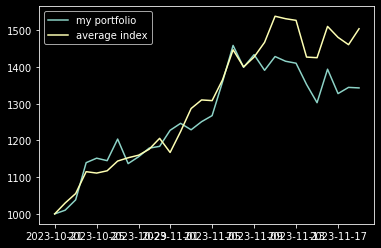

In [15]:
plt.style.use("dark_background")

plt.plot(price_data["Date"], balance_list_dynamic, label = "my portfolio")
plt.plot(price_data["Date"], balance_list_static, label = "average index")

plt.legend(loc="upper left")
plt.show()